In [1]:
from aaff import aaff,g1,g2,g3,DeltaV
from FcMole import FcM
from alch_deriv import alch_deriv
from pyscf import gto,scf
import numpy as np 
import matplotlib.pyplot as plt
from pyscf.grad import rhf as grhf
import basis_set_exchange as bse
np.set_printoptions(precision=8)

In [2]:
fmol=FcM(fcs=[.01,-.01],atom="C 0 0 0; O 0 0 2.08272",unit="Bohrs",basis='sto-6g')
fmf=scf.RHF(fmol)
fmf.scf(dm0=fmf.init_guess_by_1e())

converged SCF energy = -112.224652642075


-112.22465264207544

In [3]:
#mol=gto.M(atom="C 0 0 0; O 0 0 2.08272",unit="Bohrs",basis=bse.get_basis("pcX-2",fmt="nwchem",elements=[5,6,7,8,9]))
mol=gto.M(atom="C 0 0 0; O 0 0 2.08272",unit="Bohrs",basis='sto-6g')
mf=scf.RHF(mol)
mf.scf()
C=mf.mo_coeff
e=mf.mo_energy

converged SCF energy = -112.298401626335


In [4]:
DZ=[1,-1]
U,dP,e1=alch_deriv(mf,[[0,1],DZ])

[[0, 1], [1, -1]]


In [5]:
[x for x in range(mol.natm)]

[0, 1]

In [6]:
mol0=mf.mol
g0=mf.Gradients()
vresp = mf.gen_response(hermi=1)
P=mf.make_rdm1()
F=mf.get_fock()

In [7]:
#array([[-2.474811e-16,  2.571692e-16, -7.006909e-01],
#       [ 4.616225e-15,  2.503433e-15,  7.006912e-01]])

In [8]:
aaff(mf,[1, -1])

[[0, 1], [1, -1]]


array([[ 2.08545225e-16,  6.29298468e-16, -7.00690825e-01],
       [-2.08545225e-16, -6.29298468e-16,  7.00690825e-01]])

In [9]:
g2(mol0,dP,P,DZ,g0) # risolto problema di chiamata multpla agli integrali JK

array([[-1.56797329e-15, -2.96682233e-15,  3.96493051e+00],
       [ 1.56797329e-15,  2.96682233e-15, -3.96493051e+00]])

In [10]:
g1(mol0,dP,P,DZ,g0)

array([[ 1.67324042e-15,  3.63406863e-15, -4.90333540e+00],
       [-1.67324042e-15, -3.63406863e-15,  4.90333540e+00]])

$$-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial x}
$$
Luckily $S$ is invariant in alchemy, therefore the different in gradient is just:$$
-\sum_{\mu\nu}\frac{\partial W_{\mu\nu}}{\partial Z}\frac{\partial S_{\mu\nu}}{\partial x}
$$
### Obtaining derivatives of W
$$W_{\mu \nu}=  \sum_i ^{mo.occ.} \epsilon_i C_{\mu i} C_{\nu i}^\dagger , \ \ \ \ \ \ \ \ \ 
 \frac{\partial W}{\partial Z_I}= \sum_i ^{mo.occ.} \left( \epsilon_i (CU)_{\mu i} C_{\nu i}^\dagger + 
\epsilon_i C_{\mu i} (CU)^\dagger_{\nu i}   +\frac{\partial \epsilon_i}{\partial Z_I} C_{\mu i} C_{\nu i}^\dagger \right)$$
or:
$$ W= S^{-1} F P, \ \ \ \ \  \ \ dW= S^{-1}(FdP+PdF)$$ 

In [11]:
def g3n(mol0,dP,P,DZ,g0,vresp,F): #-dW/dZ *dS/dx
    s1=g0.get_ovlp(mol0)
    dF=vresp(dP)+DeltaV(mol0,DZ)
    S=mol0.intor_symmetric('int1e_ovlp')
    dW=np.linalg.inv(S)@((F@dP)+(dF@P))
    print(dW.shape)
    g3=np.zeros((mol0.natm,3))
    for i in range(mol0.natm):
        p0, p1 = mol0.aoslice_by_atom() [i,2:]
        g3[i] -= np.einsum('xij,ij->x', s1[:,p0:p1], dW[p0:p1]) * 2
    return(g3)

In [12]:
def dW(mol0,dP,P,DZ,g0,vresp,F): #-dW/dZ *dS/dx
    s1=g0.get_ovlp(mol0)
    dF=vresp(dP)+DeltaV(mol0,DZ)
    S=mol0.intor_symmetric('int1e_ovlp')
    dW=np.linalg.inv(S)@((F@dP)+(dF@P))
    return(dW)

In [13]:
g3n(mol0,dP,P,DZ,g0,vresp,F)
g3n(mol0,dP,P,DZ,g0,vresp,F)

(10, 10)
(10, 10)


array([[ 3.53145721e-16,  8.84947699e-17,  2.37714023e-01],
       [ 1.00186036e-15, -7.06385903e-16, -2.37713686e-01]])

In [14]:
mol0.aoslice_by_atom()

array([[ 0,  3,  0,  5],
       [ 3,  6,  5, 10]])

In [15]:
np.diag(e1[0])

array([[ 5.94527371e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -2.55123504e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -8.88146992e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.21833744e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.38587376e-16,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -8.02697473e-16,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.2053040

In [16]:
e[:7]+np.diag(e1[0])*.01,fmf.mo_energy[:7]

(array([[-20.63915104, -11.24580017,  -1.49124071,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24582569,  -1.49124071,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24580017,  -1.50012218,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24580017,  -1.49124071,  -0.7141037 ,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24580017,  -1.49124071,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24580017,  -1.49124071,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.45452184],
        [-20.69860377, -11.24580017,  -1.49124071,  -0.70888536,
          -0.57292647,  -0.57292647,  -0.4543013 ]]),
 array([-20.63917183, -11.29096405,  -1.48982676,  -0.70895957,
         -0.57232687,  -0.57232687,  -0.45596305]))

NameError: name 'dW2' is not defined

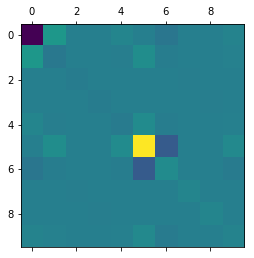

In [17]:
plt.matshow(dW(mol0,dP,P,DZ,g0,vresp,F))
plt.matshow(dW2)

$$W_{\mu \nu}=  \sum_i ^{mo.occ.} \epsilon_i C_{\mu i} C_{\nu i}^\dagger , \ \ \ \ \ \ \ \ \ 
 \frac{\partial W}{\partial Z_I}= \sum_i ^{mo.occ.} \left( \epsilon_i (CU)_{\mu i} C_{\nu i}^\dagger + 
\epsilon_i C_{\mu i} (CU)^\dagger_{\nu i}   +\frac{\partial \epsilon_i}{\partial Z_I} C_{\mu i} C_{\nu i}^\dagger \right)$$

In [ ]:
dC=C@U

In [ ]:
dW2=np.einsum('i,ji,ki->jk' ,2*e[:7],dC[:,:7],C[:,:7] )+np.einsum('i,ji,ki->jk' ,2*e[:7],C[:,:7],dC[:,:7])+ \
        2*C[:,:7]@e1[0]@C.T[:7,:]
#dW2= np.einsum('i,ji,ki->jk' ,2*np.diag(e1[0]), C[:,:7],C.T[:,:7] )
dW2

In [ ]:
dW(mol0,dP,P,DZ,g0,vresp,F)

In [ ]:
dW2.shape

In [ ]:
def t3():
    s1=g0.get_ovlp(mol0)
    t3=np.zeros((mol0.natm,3))
    for i in range(mol0.natm):
        p0, p1 = mol0.aoslice_by_atom() [i,2:]
        t3[i] -= np.einsum('xij,ij->x', s1[:,p0:p1], dW2[p0:p1])*2#(mol0,dP,P,DZ,g0,vresp,F)[p0:p1]) * 2
    return t3

In [ ]:
t3()

In [ ]:
g3n(mol0, dP, P, DZ, g0, vresp, F)

In [ ]:
t3()